## Imports and Config

In [72]:
import numpy as np
from tqdm import tqdm
import random

import gymnasium as gym

import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
# Learning parameters
GAMMA = 0.9
ALPHA = 0.1

# get locations of the colored states
env = gym.make("Taxi-v3")
RED_LOC, GREEN_LOC, YELLOW_LOC, BLUE_LOC = map(
    lambda x: x[0] * 5 + x[1], env.unwrapped.locs
)
print(RED_LOC, GREEN_LOC, YELLOW_LOC, BLUE_LOC)
env.close()

# we'll use these once we have working code
GRID_SIZE = 25
N_PRIMITIVE_MOVES = 4
N_PRIMITIVE_ACTIONS = N_PRIMITIVE_MOVES + 2
N_OPTIONS = 4
N_TOTAL_ACTIONS = N_PRIMITIVE_ACTIONS + N_OPTIONS

0 4 20 23


In [74]:
def epsilonGreedyPolicy(q_value_arr, epsilon=0.1):
    if random.random() < epsilon:
        return random.randint(0, len(q_value_arr) - 1)
    else:
        return np.argmax(q_value_arr)

In [75]:
class Option:

    def __init__(
        self,
        num_positions: int,
        num_actions: int,
        terminal_position: int,
        gamma: float = GAMMA,
        alpha: float = ALPHA,
    ):
        self.q_value = np.zeros((num_positions, num_actions))
        self.terminal_position = terminal_position
        self.gamma = gamma
        self.alpha = alpha

    def state_to_position(self, state: int):
        return state // 20

    def get_action(self, state: int, epsilon: float = 0.1):
        position = self.state_to_position(state)
        return epsilonGreedyPolicy(self.q_value[position], epsilon)

    def q_update(self, state: int, action: int, reward: float, next_state: int):
        position = self.state_to_position(state)
        next_position = self.state_to_position(next_state)
        self.q_value[position, action] += self.alpha * (
            reward
            + self.gamma * np.max(self.q_value[next_position])
            - self.q_value[position, action]
        )

    def check_done(self, state: int):
        return self.state_to_position(state) == self.terminal_position

In [76]:
class HRL:

    def __init__(
        self,
        state_size: int,
        action_size: int,
        gamma: float = GAMMA,
        alpha: float = ALPHA,
    ):
        self.q_values = np.zeros((state_size, action_size))
        self.update_freq = np.zeros((state_size, action_size))
        self.gamma = gamma
        self.alpha = alpha

    def update_primitive(self, state: int, action: int, reward: float, next_state: int):

        self.q_values[state, action] += self.alpha * (
            reward
            + self.gamma * np.max(self.q_values[next_state])
            - self.q_values[state, action]
        )
        self.update_freq[state, action] += 1

In [77]:
class SMDP_QLearning(HRL):

    def __init__(self, state_size, action_size, gamma=GAMMA, alpha=ALPHA):
        super().__init__(state_size, action_size, gamma, alpha)
        self.options = []
        for loc in [RED_LOC, GREEN_LOC, YELLOW_LOC, BLUE_LOC]:
            self.options.append(Option(25, 4, loc))

    # def update_option_midway(
    #     self, state: int, action: int, reward: float, next_state: int
    # ):
    #     return

    def update_option_end(
        self, state: int, action: int, reward: float, next_state: int, opt_duration: int
    ):
        self.q_values[state, action] += self.alpha * (
            reward
            + (self.gamma**opt_duration) * np.max(self.q_values[next_state])
            - self.q_values[state, action]
        )
        self.update_freq[state, action] += 1

In [78]:
class Trainer:

    def __init__(self, env, hrl):
        self.env = env
        self.hrl = hrl

    def train(self, num_episodes: int = 1000):

        for ep in tqdm(range(num_episodes)):
            state, _ = self.env.reset()
            done = False
            total_reward = 0
            total_reward_arr = []

            # while episode is not over
            while not done:

                # choose action
                action = epsilonGreedyPolicy(self.hrl.q_values[state])

                # if primitive action
                if action < 6:
                    next_state, reward, is_terminal, is_trunc, _ = self.env.step(action)
                    done = is_terminal or is_trunc
                    total_reward += reward
                    self.hrl.update_primitive(state, action, reward, next_state)
                    state = next_state

                # if option
                else:

                    Option = self.hrl.options[action - 6]
                    opt_start_state = state
                    opt_reward, opt_duration, opt_done = 0, 0, Option.check_done(state)

                    while not opt_done and not done:

                        # choose action
                        opt_action = Option.get_action(state)

                        # take action
                        next_state, reward, is_terminal, is_trunc, _ = self.env.step(opt_action)
                        done = is_terminal or is_trunc
                        total_reward += reward

                        # update option's q-values
                        Option.q_update(state, opt_action, reward, next_state)

                        # update reward
                        opt_reward += reward * (self.hrl.gamma**opt_duration)

                        # update q-values of hrl
                        # self.hrl.update_option_midway(
                        #     state, opt_action, reward, next_state
                        # )

                        # update variables
                        opt_duration += 1
                        state = next_state
                        opt_done = Option.check_done(state)

                    # update initial state-action pair, if needed
                    self.hrl.update_option_end(
                        opt_start_state, action, opt_reward, next_state, opt_duration
                    )
                
                
                total_reward_arr.append(total_reward)
                if done and ep % 10 == 0:
                    print("Reward: ", np.array(total_reward_arr[-10:]).mean())    

In [79]:
agent = SMDP_QLearning(500, 10)
trainer = Trainer(env, agent)
trainer.train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

  1%|          | 15/2000 [00:00<00:13, 146.93it/s]

Reward:  -221.6
Reward:  -101.9
Reward:  -233.4


  2%|▏         | 31/2000 [00:00<00:13, 151.35it/s]

Reward:  -196.3


  2%|▏         | 47/2000 [00:00<00:12, 151.65it/s]

Reward:  -195.5
Reward:  -185.7


  3%|▎         | 63/2000 [00:00<00:13, 147.42it/s]

Reward:  -144.2


  4%|▍         | 78/2000 [00:00<00:14, 132.27it/s]

Reward:  -250.5
Reward:  -256.7


  5%|▍         | 92/2000 [00:00<00:15, 126.94it/s]

Reward:  -230.5


  5%|▌         | 105/2000 [00:00<00:16, 118.40it/s]

Reward:  -253.1
Reward:  -313.4


  6%|▌         | 117/2000 [00:00<00:16, 111.90it/s]

Reward:  -178.0


  7%|▋         | 141/2000 [00:01<00:16, 112.31it/s]

Reward:  -292.7
Reward:  -365.3


  8%|▊         | 155/2000 [00:01<00:15, 117.36it/s]

Reward:  -30.7


  8%|▊         | 168/2000 [00:01<00:15, 120.29it/s]

Reward:  -77.9
Reward:  -334.1


  9%|▉         | 181/2000 [00:01<00:15, 116.13it/s]

Reward:  -295.3


 10%|▉         | 193/2000 [00:01<00:15, 113.84it/s]

Reward:  -314.5
Reward:  -182.7


 10%|█         | 209/2000 [00:01<00:14, 122.68it/s]

Reward:  -301.9


 12%|█▏        | 237/2000 [00:01<00:13, 126.70it/s]

Reward:  -122.1
Reward:  -220.8
Reward:  -52.6


 13%|█▎        | 264/2000 [00:02<00:14, 122.75it/s]

Reward:  -202.4
Reward:  -110.6
Reward:  -233.4


 15%|█▍        | 294/2000 [00:02<00:12, 132.54it/s]

Reward:  -85.7
Reward:  -282.1
Reward:  -279.3


 15%|█▌        | 308/2000 [00:02<00:12, 134.44it/s]

Reward:  -171.6


 17%|█▋        | 338/2000 [00:02<00:12, 137.60it/s]

Reward:  -2.142857142857143
Reward:  -161.9
Reward:  -180.7


 19%|█▊        | 372/2000 [00:02<00:11, 146.95it/s]

Reward:  -140.7
Reward:  -3.5
Reward:  -11.7
Reward:  -45.1


 20%|██        | 405/2000 [00:03<00:10, 152.90it/s]

Reward:  -239.6
Reward:  -285.2
Reward:  -57.2
Reward:  -279.2


 22%|██▏       | 431/2000 [00:03<00:08, 176.28it/s]

Reward:  -303.3


 22%|██▏       | 449/2000 [00:03<00:09, 165.89it/s]

Reward:  -121.3
Reward:  -304.7


 23%|██▎       | 466/2000 [00:03<00:09, 157.06it/s]

Reward:  -240.4
Reward:  -19.77777777777778


 24%|██▍       | 489/2000 [00:03<00:08, 175.64it/s]

Reward:  -68.5
Reward:  -370.7
Reward:  -50.4


 26%|██▌       | 511/2000 [00:03<00:07, 187.52it/s]

Reward:  -4.1
Reward:  -1.75


 27%|██▋       | 534/2000 [00:03<00:07, 198.33it/s]

Reward:  -2.8
Reward:  -295.1
Reward:  -72.5


 28%|██▊       | 558/2000 [00:03<00:06, 209.48it/s]

Reward:  -34.3
Reward:  -53.8


 29%|██▉       | 580/2000 [00:04<00:07, 193.22it/s]

Reward:  -3.25
Reward:  -69.5


 30%|███       | 600/2000 [00:04<00:07, 193.07it/s]

Reward:  -75.5
Reward:  -84.5


 32%|███▏      | 643/2000 [00:04<00:06, 202.09it/s]

Reward:  -59.1
Reward:  -8.5
Reward:  -43.0


 33%|███▎      | 666/2000 [00:04<00:06, 208.33it/s]

Reward:  -20.3
Reward:  -139.1


 34%|███▍      | 687/2000 [00:04<00:06, 208.18it/s]

Reward:  -20.3
Reward:  -13.3
Reward:  -271.1


 35%|███▌      | 708/2000 [00:04<00:06, 197.25it/s]

Reward:  -5.6


 37%|███▋      | 742/2000 [00:04<00:05, 234.28it/s]

Reward:  -166.1
Reward:  -36.1
Reward:  -0.4
Reward:  -14.4
Reward:  -1.4


 38%|███▊      | 770/2000 [00:04<00:05, 241.75it/s]

Reward:  -1.75
Reward:  -4.375


 41%|████      | 811/2000 [00:04<00:04, 288.86it/s]

Reward:  -1.25
Reward:  -56.1
Reward:  -68.3
Reward:  -5.7
Reward:  -122.3
Reward:  -46.7
Reward:  -46.9


 44%|████▎     | 874/2000 [00:05<00:04, 276.76it/s]

Reward:  -128.3
Reward:  -57.7
Reward:  -64.0
Reward:  -4.222222222222222
Reward:  -30.2


 46%|████▌     | 913/2000 [00:05<00:03, 301.59it/s]

Reward:  -22.8
Reward:  -71.1
Reward:  -10.333333333333334


 48%|████▊     | 950/2000 [00:05<00:03, 318.87it/s]

Reward:  -160.2
Reward:  -17.4
Reward:  -2.4
Reward:  -2.8
Reward:  -11.333333333333334


 50%|█████     | 1004/2000 [00:05<00:02, 380.50it/s]

Reward:  -46.3
Reward:  -86.5
Reward:  -88.5
Reward:  -92.1
Reward:  -23.0


 53%|█████▎    | 1061/2000 [00:05<00:02, 434.74it/s]

Reward:  3.0
Reward:  -1.75
Reward:  -40.2
Reward:  0.25
Reward:  -34.0
Reward:  -6.666666666666667
Reward:  -8.5


 56%|█████▌    | 1124/2000 [00:05<00:01, 490.36it/s]

Reward:  -0.3333333333333333
Reward:  -3.0
Reward:  -132.4
Reward:  -22.8
Reward:  -14.8
Reward:  -0.75


 59%|█████▊    | 1174/2000 [00:05<00:01, 479.50it/s]

Reward:  -0.75
Reward:  -6.2
Reward:  -13.333333333333334
Reward:  -164.9


 61%|██████    | 1223/2000 [00:05<00:01, 476.55it/s]

Reward:  -1.6
Reward:  -51.9
Reward:  -121.5
Reward:  -45.9
Reward:  -74.1
Reward:  -7.0
Reward:  -92.8


 64%|██████▍   | 1282/2000 [00:06<00:01, 509.33it/s]

Reward:  -20.9
Reward:  -29.0
Reward:  -2.2
Reward:  -1.25
Reward:  -112.7


 67%|██████▋   | 1340/2000 [00:06<00:01, 529.26it/s]

Reward:  -7.1
Reward:  -4.9
Reward:  -34.5
Reward:  -5.375
Reward:  -2.75
Reward:  -8.222222222222221
Reward:  -166.9


 70%|███████   | 1402/2000 [00:06<00:01, 555.87it/s]

Reward:  -3.25
Reward:  -48.6
Reward:  0.3333333333333333
Reward:  -10.714285714285714
Reward:  -3.5714285714285716
Reward:  -1.25


 73%|███████▎  | 1465/2000 [00:06<00:00, 572.56it/s]

Reward:  -12.333333333333334
Reward:  -42.1
Reward:  -33.7
Reward:  -25.4
Reward:  -14.4
Reward:  -3.0


 76%|███████▋  | 1526/2000 [00:06<00:00, 582.41it/s]

Reward:  -39.9
Reward:  -15.8
Reward:  -25.1
Reward:  -4.25
Reward:  -3.75
Reward:  0.75


 79%|███████▉  | 1585/2000 [00:06<00:00, 526.31it/s]

Reward:  -98.3
Reward:  -42.5
Reward:  -24.3
Reward:  -12.0


 82%|████████▏ | 1640/2000 [00:06<00:00, 532.33it/s]

Reward:  2.3333333333333335
Reward:  -5.0
Reward:  -6.0
Reward:  -3.2
Reward:  -77.5
Reward:  -11.0
Reward:  -28.3


 85%|████████▍ | 1695/2000 [00:06<00:00, 511.37it/s]

Reward:  -29.6
Reward:  -5.25
Reward:  -113.9
Reward:  -55.3


 87%|████████▋ | 1749/2000 [00:06<00:00, 518.95it/s]

Reward:  -16.1
Reward:  -38.9
Reward:  -26.2
Reward:  -42.0
Reward:  -142.7
Reward:  -2.3333333333333335
Reward:  -40.2
Reward:  -52.5


 90%|█████████ | 1809/2000 [00:07<00:00, 541.15it/s]

Reward:  -5.857142857142857
Reward:  -3.6666666666666665
Reward:  -35.5
Reward:  -83.7
Reward:  -3.25


 95%|█████████▍| 1892/2000 [00:07<00:00, 619.46it/s]

Reward:  -5.5
Reward:  -14.9
Reward:  -5.25
Reward:  -30.3
Reward:  -1.25
Reward:  -1.75
Reward:  -12.555555555555555
Reward:  -4.0
Reward:  -14.9
Reward:  -221.4


 98%|█████████▊| 1963/2000 [00:07<00:00, 644.37it/s]

Reward:  0.3333333333333333
Reward:  -4.375
Reward:  -133.3
Reward:  -2.2
Reward:  -11.1


100%|██████████| 2000/2000 [00:07<00:00, 275.57it/s]


<Axes: >

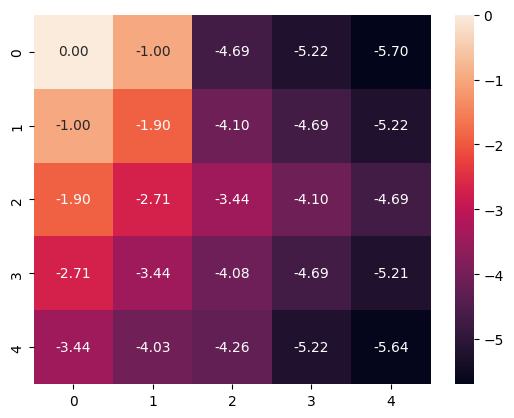

In [83]:
red_grid = agent.options[0].q_value.max(axis=1).reshape(5, 5)  
sns.heatmap(red_grid, annot=True, fmt=".2f")

<Axes: >

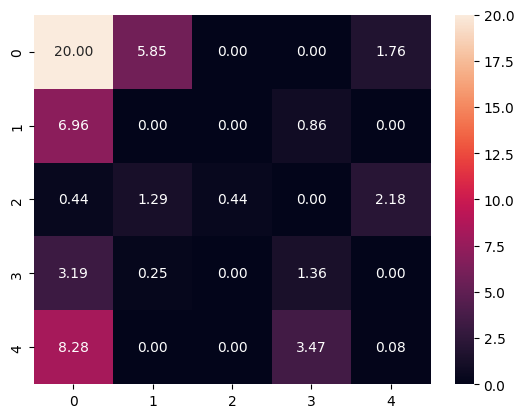

In [86]:
# select every 4th row of q_values and put it into a grid
# desination fixed to be red

grid = agent.q_values[::4].max(axis=1)
grid = grid.reshape(5, 5, 5)
grid = grid.max(axis=2)
sns.heatmap(grid, annot=True, fmt=".2f")